# Character RNN
#### Description:
We implement a character-level recurrent neural network using the GRU as our recurrent unit. We train the CharRNN on Hamilton lyrics, and get some interesting results.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim

import os
import zipfile
import matplotlib.pyplot as plt

import string
import random
import time

# Dataset Class

In [53]:
class TextDataset(Dataset):
    def __init__(self, chunk_len=200, file_name="michael-jackson.txt"):
        """Creates a Pytorch Dataset from a text corpus.
        Args:
            chunk_len (int): the length of each training segment of text
            file_name (str): the name of the file to train on. A full list of files is found here: https://www.kaggle.com/paultimothymooney/poetry
        """
        
        root = '../data/'
            
        text_files = os.listdir(root)
        self.training_file = text_files[text_files.index(file_name)]
        with open(os.path.join(root, self.training_file), encoding='utf-8') as file:
            self.training_file = file.read()
        self.segment_extractor = self.FileSegmentExtractor(self.training_file, chunk_len)

    @staticmethod
    def extract_zip(zip_path):
        """Extraxts a file in .zip format to the root directory
        Args:
            zip_path (str): the path to the zip file
        """
        print('Unzipping {}'.format(zip_path))
        with zipfile.ZipFile(zip_path,"r") as zip_ref:
            zip_ref.extractall(os.path.dirname(self.root))
    
    def __len__(self):
        return self.len
        
    class FileSegmentExtractor():
        def __init__(self, training_file, chunk_len):
            """Extracts chunk_len segments from the data for training
            Args:
                training_file (str): the training file path
                chunk_len (int): the number of characters in each chunk
            """
            self.chunk_len = chunk_len
            self.training_file = training_file
            self.file_len = len(self.training_file)
            # A string including all printable characters
            self.all_characters = string.printable
            self.n_characters = len(self.all_characters)
            
        def random_chunk(self):
            """Extracts a random chunk from the file
            Returns:
                (str): a string of length (chunk_len)
            """
            start_index = random.randint(0, self.file_len - self.chunk_len)
            end_index = start_index + self.chunk_len + 1
            return self.training_file[start_index:end_index]

        def char_tensor(self, string):
            """Converts characters in a string to a numerical index representing that character.
            Args:
                string (str): the string to convert
            Returns:
                tensor (torch.Tensor): a tensor containing the indices of each letter in the string
            """
            tensor = torch.zeros(len(string)).long()
            for c in range(len(string)):
                try:
                    tensor[c] = self.all_characters.index(string[c])
                except ValueError:
                    tensor[c] = self.all_characters.index(' ')
            return tensor

        
        def random_training_set(self):
            """Obtains a random set of data to train on.
            Returns:
                inp (torch.Tensor): a chunk of characters from the file
                target (torch.Tensor): the same chunk of characters offset by one
            """
            chunk = self.random_chunk()
            inp = self.char_tensor(chunk[:-1])
            target = self.char_tensor(chunk[1:])
            return inp, target

# Take a look at the data

In [84]:
print(TextDataset(file_name='lin-manuel-miranda.txt').segment_extractor.random_chunk())

hrowing away my shot
Hey yo, I'm just like my country
I'm young, scrappy and hungry
And I'm not throwing away my shot We're gonna rise up (time to take a shot)
We're gonna rise up (time to take a shot)


# GRU Implementation

In [61]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        """A gated recurrent unit, described here: https://en.wikipedia.org/wiki/Gated_recurrent_unit
        Args:
            input_size (int): the dimension of the input of the GRU.
            hidden_size (int): the dimension of the hidden state outputs of the GRU. 
        """
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.wr = nn.Linear(input_size + hidden_size, hidden_size)
        self.wz = nn.Linear(input_size + hidden_size, hidden_size)
        self.w = nn.Linear(input_size + hidden_size, hidden_size)
        
    def forward(self, x_input, prev_hidden):
        """A forward pass of an input through the model. Follows the 'fully-gated' GRU architecture
        Args:
            x_input ((self.input_size) torch.Tensor): an integer-encoded token
            prev_hidden ((self.hidden_size) torch.Tensor): the hidden layer output of the previous GRU
        Returns:
            ht ((self.hidden_size) torch.Tensor): the resulting hidden layer representation
            ht ((self.hidden_size) torch.Tensor): another copy of the hidden layer, which will go
                through one more transformation to become the output token prediction.
        """
        zt = self.sig(self.wz(torch.cat((x_input, prev_hidden), dim=2)))
        rt = self.sig(self.wr(torch.cat((x_input, prev_hidden), dim=2)))
        h_tilde = self.tanh(self.w(torch.cat((torch.mul(rt, prev_hidden), x_input), dim=2)))
        ht = torch.mul((1 - zt), prev_hidden) + torch.mul(zt, h_tilde)
        return ht, ht

# RNN

In [56]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        """A full recurrent neural network, built around a GRU.
        Args:
            input_size (int): the dimension of the input to the network - in the 
                case of our CharRNN, it is len(alphabet). 
            hidden_size (int): the dimension of the hidden state outputs of the GRU. 
            output_size (int): the dimension of the output of the network. Note that 
                the output size is the same as the input size.
            n_layers (int): the number of layers in the RNN
        """
        super(RNN, self).__init__()
        # Input: An integer encoding of the character
        self.input_size = input_size
        # Output: A categorical distribution over characters
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # An embedding layer is different from a linear layer because it provides
        # lookup capability -- each character has its own trained embedding. A
        # linear layer is different, as all input characters share the same weights
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        # The first argument is self.hidden_size because we've embedded the input to be the same size as the hidden_state
        self.gru = GRU(self.hidden_size, self.hidden_size)
        self.to_output_size = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1) #dim=1

    def forward(self, input_char, hidden_state):
        """A forward pass through the RNN.
        Args:
            input_char (int): an integer-encoded character
            hidden_state ((self.hidden_size) torch.Tensor): the hidden state output of the previous layer
        """
        embed = self.embedding(input_char).view(1,1,-1)
        output, hidden = self.gru(embed, hidden_state)
        output = self.relu(self.to_output_size(output))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

# Training Loop

In [79]:
def step(input_string, target_string, decoder, decoder_optimizer, criterion):
    """Takes one step of training
    Args:
        input_string (torch.Tensor): a string of characters each encoded to a unique integer
            and stored in a tensor
        target_string (torch.Tensor): a string of characters each encoded to a unique integer
            and stored in a tensor. The same as the input string, but offset by one.
        decoder (torch.nn.Module): the RNN model
        decoder_optimizer (torch.optim.Optimizer): the optimizer for the model
        criterion (torch.nn.modules.loss._Loss): the objective function
    Returns:
        (torch.Tensor): a zero-dimensional tensor holding the loss-per-character
    """
    # initialize hidden layers, set up gradient and loss
    loss = 0
    hidden = decoder.init_hidden()
    num_classes = len(string.printable)
    i = 0
    decoder_optimizer.zero_grad()
    
    for in_char, target_char in zip(input_string, target_string):
        
        
        char_hat, hidden = decoder(in_char, hidden)
        target_char = target_char.unsqueeze(0)
        loss += criterion(char_hat.squeeze(0), target_char)
    
        i += 1
        
    loss.backward()
    decoder_optimizer.step()
        
    return loss.item() / len(input_string)
        
def char_tensor(chars):
    """Converts characters in a string to a numerical index representing that character.
    Args:
        chars (str): the string to convert
    Returns:
        tensor (torch.Tensor): a tensor containing the indices of each letter in the string
    """
    all_characters = string.printable    
    tensor = torch.zeros(len(chars)).long()
    for c in range(len(chars)):                
        tensor[c] = all_characters.index(chars[c])
    return tensor

def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    """Samples from the trained RNN
    Args:
        decoder (torch.nn.Module): the RNN
        prime_str (str): a string to prime the model
        predict_len (int): the number of characters to predict
        temperature (float in [0, 1]): the amount of randomness in the sample
    Returns:
        predicted (str): a predicted string
    """
    hidden = decoder.init_hidden()
    predicted = prime_str
    prime_input = char_tensor(prime_str)
    all_characters = string.printable  

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for p in range(predict_len):

        output, hidden = decoder(inp, hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        char_choice = all_characters[top_i]
        inp = char_tensor(char_choice)
        predicted += char_choice

    return predicted 

def train(n_epochs=5000, print_every=500, plot_every=10, hidden_size=100, n_layers=1,
          lr=0.005, file_name="michael-jackson.txt"):
    """Trains a RNN according to the given parameters
    Args:
        n_epochs (int): the number of epochs to train for
        print_every (int): how often to print an evaluation string
        plot_every (int): how often to track the training loss
        hidden_size (int): the hidden dimension of the recurrent unit
        n_layers (int): the number of layers in the model
        lr (float): the learning rate for the model
        file_name (str): the name of the file to train on. Options: ['al-green.txt', 'Kanye_West.txt', 
            'britney-spears.txt', 'kanye-west.txt', 'notorious-big.txt', 'patti-smith.txt', 'prince.txt', 
            'leonard-cohen.txt', 'dolly-parton.txt', 'janisjoplin.txt', 'amy-winehouse.txt', 'dr-seuss.txt', 
            'rihanna.txt', 'adele.txt', 'eminem.txt', 'bjork.txt', 'radiohead.txt', 'missy-elliott.txt', 
            'beatles.txt', 'bruce-springsteen.txt', 'Lil_Wayne.txt', 'nickelback.txt', 'blink-182.txt', 
            'drake.txt', 'joni-mitchell.txt', 'bob-marley.txt', 'nicki-minaj.txt', 'lady-gaga.txt', 
            'kanye.txt', 'lorde.txt', 'bob-dylan.txt', 'lil-wayne.txt', 'dickinson.txt', 'bruno-mars.txt', 
            'alicia-keys.txt', 'r-kelly.txt', 'ludacris.txt', 'bieber.txt', 'nursery_rhymes.txt', 
            'michael-jackson.txt', 'dj-khaled.txt', 'lin-manuel-miranda.txt', 'paul-simon.txt', 'cake.txt', 
            'johnny-cash.txt', 'notorious_big.txt', 'nirvana.txt', 'jimi-hendrix.txt', 'disney.txt']
    """    
    all_characters = string.printable
    in_size=len(all_characters)
    output_size = len(all_characters)
    
    train_dataset = TextDataset(file_name=file_name)
    
    decoder = RNN(in_size, hidden_size, output_size, n_layers=n_layers)
    
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    all_losses = []
    running_loss = 0
    start = time.time()
    for epoch in range(n_epochs + 1):
        
        input_string, target_string = train_dataset.segment_extractor.random_training_set()
        loss_ = step(input_string, target_string, decoder, decoder_optimizer, criterion)
        running_loss += loss_
        
        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
            print(evaluate(decoder, 'Wh', 100), '\n')
            
        if epoch % plot_every == 0:
            all_losses.append(running_loss / (epoch + 1))
            
    plt.plot(range(len(all_losses)), all_losses, label='Loss')
    plt.xlabel("Epoch / {}".format(plot_every))
    plt.ylabel("Loss")

# Results - Alexander Hamilton is not throwing away his shot!

[0.1623687744140625 (0 0%) 4.5989]
WhX8x~lI)x+P9
4hJw0Y7fVh	oj:_PJssEI`\3Hdw(+kRG#Gf`CN-8 }mv}v e_?$&UJWb}o8x}9Wuh)RS0~VG"^fZ
at?o1*:[c 

[81.7245922088623 (500 5%) 1.9224]
What's sint
I'm and me pitent a rest withe alto never and sent for in anothesina coleplains and I deak 

[161.752427816391 (1000 10%) 0.9795]
Where's have you shot to have this will have you wan the sad
Will the were What the could have we deat 

[241.7951946258545 (1500 15%) 1.4527]
Who me
I'm wait for bot hand me who are mys many many and and moshine, but Aled|ary sholdrops in the m 

[322.07968401908875 (2000 20%) 1.3755]
Whot, I do I make regoals on Secret whoul
Ham low in parteed in for it
Wait for it
Wait for the rose c 

[399.7305579185486 (2500 25%) 1.6160]
When America got the sain
Wondent to milly will not words ears the bed Ale, sir, of a back is my coall 

[477.75779724121094 (3000 30%) 1.3693]
When dead of colonectress And if we reary
One with somern, are been on wis so pirtuat
A corse I'm what 

[556

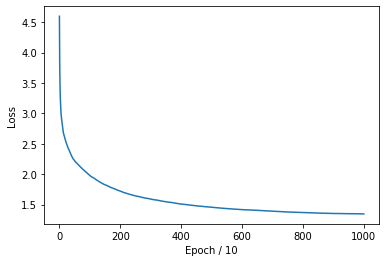

In [82]:
train(n_epochs=10000, file_name='lin-manuel-miranda.txt')